In [ ]:
import os
import time
import random
import numpy as np
from numpy import argmax
import pandas as pd
import json
from collections import OrderedDict, namedtuple
from itertools import product
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# Enable GPU processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device type: {device}')

Device type: cuda


In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
# Set random seed
seed = 777
torch.manual_seed(seed)

In [ ]:
# Define data directory parameters
datadir = '/drive/My Drive/'
traindir = datadir + 'trainf/'
validdir = datadir + 'validf/'
testdir = datadir + 'testf/'

In [ ]:
# Confirm image class distribution

# Empty lists
classes = []
n_train = []
n_valid = []
n_test = []

# Iterate through each category
for d in os.listdir(traindir):
    classes.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

print(f'Classes: {classes}')
print(f'Training images per class: {n_train}')
print(f'Validation images per class: {n_valid}')
print(f'Test images per class: {n_test}')

Classes: ['HER2', 'Luminal', 'Triple', 'ER_PR_HER2']
Training images per class: [400, 401, 400, 400]
Validation images per class: [101, 101, 101, 101]
Test images per class: [201, 201, 201, 201]


In [ ]:
# Define an image transformations dictionary
image_transforms = {
    # Training set uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.RandomAffine(degrees=(0,30)),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet standards
    ]),
    # No image augmentation for the validation and test sets
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

In [ ]:
# Review the transfer learning model: using VGG-16
review_model = models.vgg16(pretrained=True)
print(review_model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Create our CNN model by modifying the output layer of the transfer learning model
def CNN_model(hidden_units, dropout, num_classes):
  transfer_model = models.vgg16(pretrained=True)

  # freeze the weights from training in the transfer learning model
  for param in transfer_model.parameters():
    param.requires_grad = False

  # define the overall CNN model
  model = transfer_model
  model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(dropout, inplace=False),
    nn.Linear(in_features=4096, out_features=hidden_units),
    nn.ReLU(inplace=True),
    nn.Dropout(dropout, inplace=False),
    nn.Linear(hidden_units, num_classes),
    nn.LogSoftmax(dim=1)
  )

  return model

In [ ]:

# Test model creation
test_model = CNN_model(256, 0.4, 4)
print(test_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Define a class to build run execution sets based on a dictionary of hyperparameters
class RunBuilder():
  @staticmethod
  def get_runs(params):
    Run = namedtuple('Run', params.keys())
    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    return runs

In [ ]:
# Create a class to manage the training / hyperparameter runs
class RunManager():
  def __init__(self):
    self.epoch_count = 0
    self.train_loss = 0
    self.train_num_correct = 0
    self.val_loss = 0
    self.val_num_correct = 0

    self.run_params = None
    self.run_count = 0
    self.run_data = []

    self.model = None
    self.train_loader = None
    self.val_loader = None
    self.tb = None

  def begin_run(self, run, model, train_loader, val_loader):
    self.run_params = run
    self.run_count += 1
    self.model = model.to(device)
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.tb = SummaryWriter(log_dir=traindir + '/runs', max_queue=20, comment=f'-{run}')
    images, labels = next(iter(self.train_loader))
    images, labels = images.to(device), labels.to(device)
    self.tb.add_graph(self.model, images)

  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  def begin_epoch(self):
    self.epoch_count += 1
    self.train_loss = 0
    self.train_num_correct = 0
    self.val_loss = 0
    self.val_num_correct = 0

  def end_epoch(self):
    train_loss = self.train_loss / len(self.train_loader.dataset)
    train_accuracy = self.train_num_correct / len(self.train_loader.dataset)
    val_loss = self.val_loss / len(self.val_loader.dataset)
    val_accuracy = self.val_num_correct / len(self.val_loader.dataset)

    self.tb.add_scalar('Train Loss', train_loss, self.epoch_count)
    self.tb.add_scalar('Train Accuracy', train_accuracy, self.epoch_count)
    self.tb.add_scalar('Val Loss', val_loss, self.epoch_count)
    self.tb.add_scalar('Val Accuracy', val_accuracy, self.epoch_count)

    for name, param in self.model.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      #self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)

    print(f'Epoch: {self.epoch_count}, Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.3f}')
    print(f'Epoch: {self.epoch_count}, Valid Loss: {val_loss:.3f}, Valid Acc: {val_accuracy:.3f}')

    results = OrderedDict()
    results['run'] = self.run_count
    results['epoch'] = self.epoch_count
    results['train loss'] = train_loss
    results['train acc'] = train_accuracy
    results['valid loss'] = val_loss
    results['valid acc'] = val_accuracy

    for k, v in self.run_params._asdict().items():
      results[k] = v

    self.run_data.append(results)

  def track_loss(self, loss, mode):
    if mode == 'train':
      self.train_loss += loss.item() * self.train_loader.batch_size
    elif mode == 'val':
      self.val_loss += loss.item() * self.val_loader.batch_size

  def track_num_correct(self, preds, labels, mode):
    if mode == 'train':
      self.train_num_correct += preds.argmax(dim=1).eq(labels).sum().item()
    elif mode == 'val':
      self.val_num_correct += preds.argmax(dim=1).eq(labels).sum().item()

  def save_output(self, filename):
    if filename:
      filename = traindir + filename
      pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{filename}.csv')

      # with open(f'{filename}.json', 'w', encoding='utf-8') as f:
      #   json.dump(self.run_data, f, ensure_ascii=False, indent=4)

      print('Results saved to disk')

    return pd.DataFrame.from_dict(self.run_data, orient='columns')


In [ ]:
# Define training loop execution
def execution_loop(filename):
  m = RunManager()
  for run in RunBuilder.get_runs(params):

    # instantiate the neural network model
    model = CNN_model(run.hidden_units, run.dropout, run.num_classes)
    optimizer = Adam(model.parameters(), lr=run.lr)

    # Define the data loaders
    dataloaders = {
        'train': DataLoader(data['train'], batch_size=run.batch_size, shuffle=True, num_workers=1),
        'val': DataLoader(data['val'], batch_size=run.batch_size, shuffle=False, num_workers=1)
    }

    train_loader = dataloaders['train']
    val_loader = dataloaders['val']

    m.begin_run(run, model, train_loader, val_loader)
    for epoch in range(run.n_epochs):
      m.begin_epoch()
      for batch in train_loader:
        with torch.set_grad_enabled(True):
          # get inputs/targets and move tensors to GPU
          images, labels = batch[0].to(device), batch[1].to(device)
          # clear previous gradients
          optimizer.zero_grad()
          # make prediction
          yhat = model(images)
          # calculate the loss
          loss = F.nll_loss(yhat, labels)
          # perform back prop
          loss.backward()
          # update model weights
          optimizer.step()

          m.track_loss(loss, 'train')
          m.track_num_correct(yhat, labels, 'train')

      else:
        with torch.no_grad():
          for batch in val_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            output = model(images)
            loss = F.nll_loss(output, labels)

            m.track_loss(loss, 'val')
            m.track_num_correct(output, labels, 'val')

      m.end_epoch()
    m.end_run()
  return model, m.save_output(filename)

In [ ]:
# Define training run hyperparameters
params = OrderedDict(
    hidden_units = [256, 512],
    dropout = [0.4, 0.5],
    num_classes = [4],
    lr = [0.001],
    batch_size = [25],
    n_epochs = [15]
)

In [ ]:
model, history = execution_loop('Run_Results')

Epoch: 1, Train Loss: 1.785, Train Acc: 0.302
Epoch: 1, Valid Loss: 1.376, Valid Acc: 0.376
Epoch: 2, Train Loss: 1.256, Train Acc: 0.403
Epoch: 2, Valid Loss: 1.342, Valid Acc: 0.384
Epoch: 3, Train Loss: 1.153, Train Acc: 0.448
Epoch: 3, Valid Loss: 1.101, Valid Acc: 0.515
Epoch: 4, Train Loss: 1.057, Train Acc: 0.509
Epoch: 4, Valid Loss: 1.167, Valid Acc: 0.478
Epoch: 5, Train Loss: 0.919, Train Acc: 0.583
Epoch: 5, Valid Loss: 0.924, Valid Acc: 0.629
Epoch: 6, Train Loss: 0.860, Train Acc: 0.639
Epoch: 6, Valid Loss: 0.917, Valid Acc: 0.604
Epoch: 7, Train Loss: 0.721, Train Acc: 0.690
Epoch: 7, Valid Loss: 0.872, Valid Acc: 0.631
Epoch: 8, Train Loss: 0.655, Train Acc: 0.735
Epoch: 8, Valid Loss: 0.698, Valid Acc: 0.757
Epoch: 9, Train Loss: 0.580, Train Acc: 0.769
Epoch: 9, Valid Loss: 0.814, Valid Acc: 0.668
Epoch: 10, Train Loss: 0.484, Train Acc: 0.826
Epoch: 10, Valid Loss: 0.859, Valid Acc: 0.745
Epoch: 11, Train Loss: 0.455, Train Acc: 0.833
Epoch: 11, Valid Loss: 0.454, V

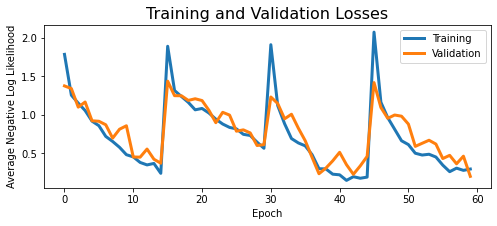

In [ ]:
# View single run loss curves
plt.figure(figsize=(8, 3))
plt.plot(history['train loss'], label='Training', linewidth=3)
plt.plot(history['valid loss'], label='Validation', linewidth=3)
plt.title('Training and Validation Losses', fontsize=16)
plt.ylabel('Average Negative Log Likelihood')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show();

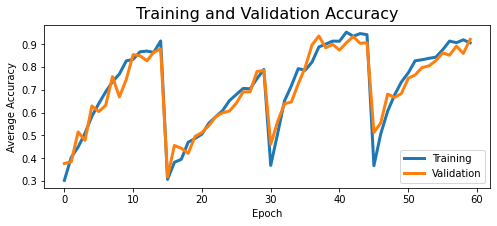

In [ ]:
# View single run accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(history['train acc'], label='Training', linewidth=3)
plt.plot(history['valid acc'], label='Validation', linewidth=3)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.ylabel('Average Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show();


In [ ]:
# Function to evaluate the model on the test set
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
def evaluate_model(test_dl, model):
    device='cpu'
    model=model.to(device)
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        inputs = inputs.to(device)
        targets = targets.to(device)
        yhat = model(inputs)

        # retrieve numpy array
        yhat = yhat.detach().numpy()
        yhat=np.argmax(yhat, axis=1)
       # yhat = torch.argmax(yhat,axis=1)
        #actual = targets.cpu().data.numpy().argmax()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        #print(yhat)
        #print(actual)
        #yhat.numpy()
        # store
        yhat=yhat.tolist()
        predictions.append(yhat)
        actuals.append(actual)
    #print(predictions)
    #print(actuals)
    #print(predictions,actuals)
    #predictions = predictions.
    actuals =np.vstack(actuals)
    #print(actuals)
    #print(predictions.shape,actuals.shape)
    #act = actuals.flatten()
    act = list(np.concatenate(actuals))
    pred = list(np.concatenate(predictions))
    #print(pred)
    #print(act)
    #print(len(pred),len(act))
    # calculate accuracy
    acc = accuracy_score(act, pred)
    f1 = f1_score(act, pred,average='weighted')
    class_labels=['HER2', 'Luminal', 'Triple', 'ER_PR_HER2']
    report = metrics.classification_report(act, pred, target_names=class_labels)
    print(report)
    return acc,f1

In [ ]:
test_dl = DataLoader(data['test'], batch_size=25, shuffle=False, num_workers=1)
#evaluate_model(test_dl, model)

test_acc, test_f1 = evaluate_model(test_dl, model)
print("--Evaluation Metrics--")
print("Test Accuracy: ",test_acc)
print("F1 Score: ",test_f1)


              precision    recall  f1-score   support

        HER2       0.97      0.94      0.95       201
     Luminal       0.96      0.98      0.97       201
      Triple       0.90      0.85      0.87       201
  ER_PR_HER2       0.84      0.91      0.87       201

    accuracy                           0.92       804
   macro avg       0.92      0.92      0.92       804
weighted avg       0.92      0.92      0.92       804

--Evaluation Metrics--
Test Accuracy:  0.9166666666666666
F1 Score:  0.9168057689293903
